In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import sys

In [2]:
import tools as tl

In [3]:
print(sys.version)
print(np.__version__)
print(cv2.__version__)

3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
1.18.5
4.5.1


# Init function

In [4]:
def getGradient(gray, x = 0, y = 0, useGradient = True):
    if useGradient:
        grad = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=x, dy=y, ksize=3)

        '''
            take absolute value of gradient to use negative gradient
        '''
        grad = np.absolute(grad)

        '''
            Normalization of gradient
        '''
        (minVal, maxVal) = (np.min(grad), np.max(grad)) 
        if maxVal - minVal > 0:
            grad = (255 * ((grad - minVal) / float(maxVal - minVal))).astype("uint8")
        else:
            grad  = np.zeros(gray.shape, dtype = "uint8")

    else:
        grad = cv2.adaptiveThreshold(  gray,
                                        255,
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV,
                                        11,
                                        2)

    return grad

# Process image

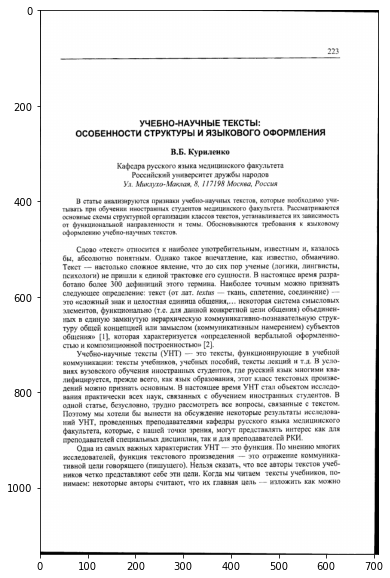

In [5]:
img = cv2.imread('3.png', 0)
vis = cv2.imread('3.png')
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, cmap='gray')
plt.show()


In [6]:
bin_img = getGradient(img, x = 1, useGradient = True)
# fig, ax = plt.subplots(figsize=(15, 15))
# ax.imshow(bin_img, cmap='gray')
# plt.show()

In [7]:
verp = np.sum(bin_img, axis=1) / 255
drawedverp = tl.getDrawProjectionVer(img, verp)

## Find filter size

In [8]:
half = int(np.max(verp) / 2)
sliceLine = drawedverp[:,(half-1):(half+1)]
contours, hierarchy = cv2.findContours(cv2.cvtColor(   sliceLine, 
                                                       cv2.COLOR_BGR2GRAY), 
                                                       cv2.RETR_EXTERNAL, 
                                                       cv2.CHAIN_APPROX_SIMPLE)

In [9]:
print(half)

139


In [10]:
heights = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    heights.append(h)
print(heights)

[7, 8, 8, 8, 8, 7, 8, 8, 8, 7, 7, 7, 7, 8, 8, 7, 6, 8, 8, 9, 8, 8, 8, 8, 7, 8, 8, 7, 7, 7, 7, 7, 2, 1, 7, 13]


In [11]:
medianHeight = int(np.median(np.asarray(heights)) * 1.5)
print("medianHeight", medianHeight)

medianHeight 12


In [12]:
drawedverp = cv2.line(drawedverp, 
                      (half,0), 
                      (half,drawedverp.shape[0]), 
                      (0,0,255), 
                      1)
print(drawedverp)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


## Convolve peaks

In [13]:
kernel = medianHeight
verpConvolved = np.convolve(verp, np.ones((kernel,))/kernel, mode='same')
drawedverpconv = tl.getDrawProjectionVer(img, verpConvolved)

print(verpConvolved)

[1.94150327 2.09313725 2.20392157 ... 3.26764706 3.10163399 2.93562092]


## Find peaks

In [14]:
bandP1ranges = []
peaks = []
c1 = 0.2
c2 = 0.4
print(verpConvolved[1])
while np.max(verpConvolved) > 40:
    ybm = np.argmax(verpConvolved)
    print(ybm)

    yb0 = tl.findb0(verpConvolved, 
                    ybm, 
                    c1 * verpConvolved[ybm])
    yb1 = tl.findb1(verpConvolved, 
                    ybm, 
                    c2 * verpConvolved[ybm])

    if yb1 - yb0 > medianHeight:
        bandP1ranges.append((yb0,yb1))
        peaks.append((int(verpConvolved[ybm]), ybm))

    verpConvolved[yb0:yb1] = 0

print(verpConvolved)

2.093137254901961
257
666
863
954
972
434
990
328
364
266
468
998
298
[1.94150327 2.09313725 2.20392157 ... 3.26764706 3.10163399 2.93562092]


In [15]:
# draw peaks
for peak in peaks:
    cv2.circle(drawedverpconv, peak, 5, (255,0,0), -1)
    print(len(drawedverpconv))

1139
1139
1139
1139
1139
1139
1139
1139
1139
1139
1139


In [16]:
# draw bands
bandsImg = np.zeros(vis.shape, dtype = np.uint8)
for band in bandP1ranges:
    print(band)
    yt, yb = band
    
    bandsImg[yt:yb] = [0,255,0]
print(yt,yb)    

(228, 266)
(493, 674)
(673, 871)
(870, 962)
(961, 980)
(392, 457)
(979, 998)
(318, 335)
(334, 373)
(456, 474)
(288, 306)
288 306


In [17]:
vis = cv2.addWeighted(vis, 0.6, bandsImg, 0.4, 0)

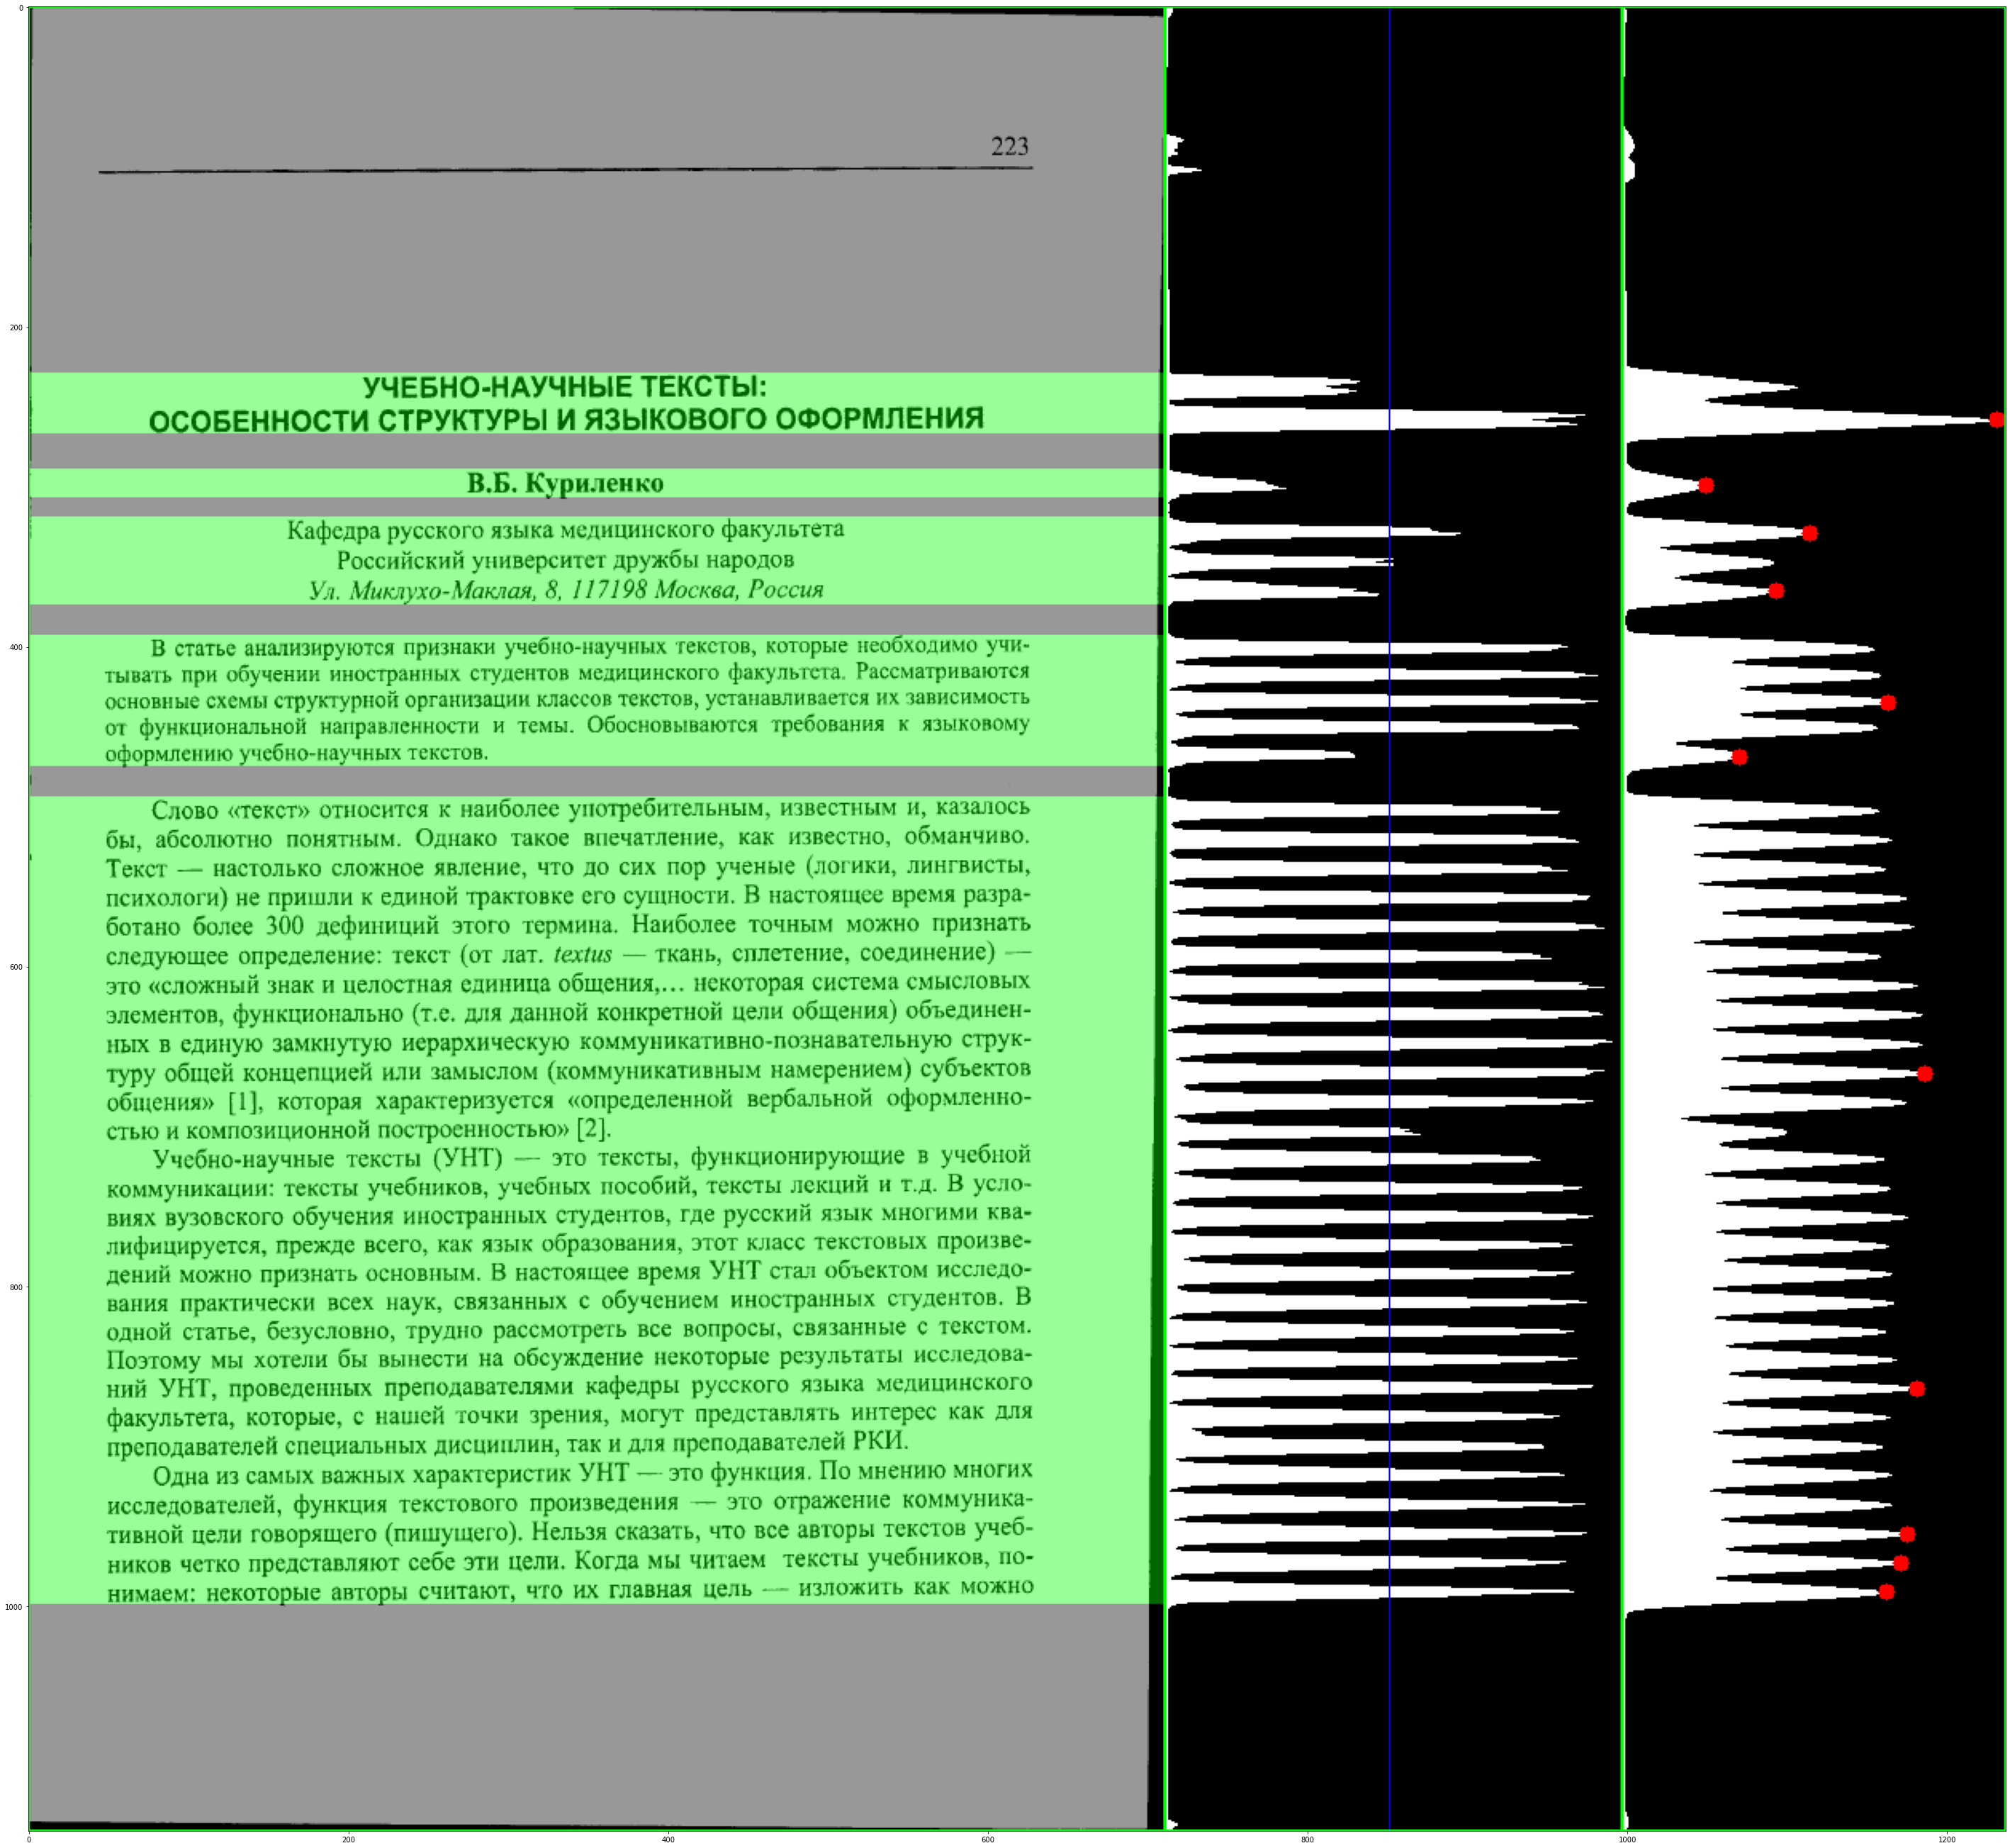

In [18]:
bigImg1 = tl.concat_hor((vis, drawedverp, drawedverpconv))
fig, ax = plt.subplots(figsize=(50, 50))
ax.imshow(bigImg1, cmap='gray')
plt.show()